In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pyspark

In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Pricing and Load data") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()

#Loading Pricing Data

In [ ]:
from pyspark.sql import SparkSession
import zipfile
import os

# Paths
base_dir = "/content/drive/Shareddrives/DATS6450-Project4/"
extract_base = "/content/drive/Shareddrives/DATS6450-Project4/"
all_files = []
monthly_data = []

# Month-wise processing
for month in range(1, 13):
    mm = str(month).zfill(2)
    zip_path = os.path.join(base_dir, f"2001{mm}01realtime_zone_csv.zip")
    extract_path = os.path.join(extract_base, f"pricing_2001_{mm}")
    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Load all CSVs from this month into a DataFrame and add a 'month' column
    df = spark.read.option("header", True).csv(f"{extract_path}/*.csv")
    monthly_data.append(df)

# Combine all months into a single DataFrame
pricing_data = monthly_data[0]
for df in monthly_data[1:]:
    pricing_data = pricing_data.unionByName(df)


pricing_data.show(5)


+-------------------+------+-----+-------------+-----------------------------+---------------------------------+
|         Time Stamp|  Name| PTID|LBMP ($/MWHr)|Marginal Cost Losses ($/MWHr)|Marginal Cost Congestion ($/MWHr)|
+-------------------+------+-----+-------------+-----------------------------+---------------------------------+
|01/30/2001 00:00:00|CAPITL|61757|        34.13|                         3.15|                             0.00|
|01/30/2001 00:00:00|CENTRL|61754|        29.81|                        -1.17|                             0.00|
|01/30/2001 00:00:00|DUNWOD|61760|        32.49|                         1.51|                             0.00|
|01/30/2001 00:00:00|GENESE|61753|        30.63|                        -0.35|                             0.00|
|01/30/2001 00:00:00|   H Q|61844|        31.08|                         0.10|                             0.00|
+-------------------+------+-----+-------------+-----------------------------+------------------

# Loading Load Data

In [ ]:
load_data_list = []

# Process months 05 to 12 of 2001
for month in range(5, 13):
    mm = str(month).zfill(2)
    zip_name = f"2001{mm}01pal_csv.zip"
    zip_path = os.path.join(base_dir, zip_name)
    extract_path = os.path.join(extract_base, f"load_2001_{mm}")
    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    df = spark.read.option("header", True).csv(f"{extract_path}/*.csv")
    load_data_list.append(df)

load_data = load_data_list[0]
for df in load_data_list[1:]:
    load_data = load_data.unionByName(df)

load_data.show(5)

+-------------------+---------+------+-----+----+
|         Time Stamp|Time Zone|  Name| PTID|Load|
+-------------------+---------+------+-----+----+
|05/29/2001 00:00:00|      EDT|CAPITL|61757| 885|
|05/29/2001 00:00:00|      EDT|CENTRL|61754|1331|
|05/29/2001 00:00:00|      EDT|DUNWOD|61760| 438|
|05/29/2001 00:00:00|      EDT|GENESE|61753| 765|
|05/29/2001 00:00:00|      EDT|HUD VL|61758| 907|
+-------------------+---------+------+-----+----+
only showing top 5 rows



##Merging pricing and load data on Timestamp, Name and PTID column

In [ ]:
from pyspark.sql.functions import col

# Ensure matching column names and formats
pricing_data_clean = pricing_data.withColumnRenamed("Time Stamp", "timestamp") \
                                 .withColumnRenamed("LBMP ($/MWHr)", "LBMP") \
                                 .withColumnRenamed("Marginal Cost Losses ($/MWHr)", "Losses") \
                                 .withColumnRenamed("Marginal Cost Congestion ($/MWHr)", "Congestion")

load_data_clean = load_data.withColumnRenamed("Time Stamp", "timestamp")

# Join on timestamp, Name, and PTID
combined_data = pricing_data_clean.join(
    load_data_clean,
    on=["timestamp", "Name", "PTID"],
    how="inner"
)

# Show top 5 rows
print("=== Combined Pricing and Load Data ===")
combined_data.show(5)


=== Combined Pricing and Load Data ===
+-------------------+------+-----+-----+------+----------+---------+----+
|          timestamp|  Name| PTID| LBMP|Losses|Congestion|Time Zone|Load|
+-------------------+------+-----+-----+------+----------+---------+----+
|05/26/2001 00:00:00|CAPITL|61757|20.52|  1.06|      0.00|      EDT| 985|
|05/26/2001 00:00:00|CENTRL|61754|19.00| -0.46|      0.00|      EDT|1461|
|05/26/2001 00:00:00|GENESE|61753|18.88| -0.58|      0.00|      EDT| 830|
|05/26/2001 00:00:00|MILLWD|61759|20.28|  0.82|      0.00|      EDT| 166|
|05/26/2001 00:00:00| NORTH|61755|19.44| -0.02|      0.00|      EDT| 659|
+-------------------+------+-----+-----+------+----------+---------+----+
only showing top 5 rows



In [ ]:
combined_data.coalesce(1).write \
    .option("header", True) \
    .mode("overwrite") \
    .csv("/content/drive/Shareddrives/DATS6450-Project4/combined_data")

# Split into train and streaming data

In [ ]:
combined_data = spark.read.option("header", True).csv("/content/drive/Shareddrives/DATS6450-Project4/combined_data/*.csv")

In [ ]:
from pyspark.sql.functions import month, to_timestamp

combined_data = combined_data.withColumn("timestamp", to_timestamp("timestamp", "MM/dd/yyyy HH:mm:ss"))

streaming_data = combined_data.filter(month("timestamp").isin([3, 6, 9, 12]))
training_data = combined_data.filter(~month("timestamp").isin([3, 6, 9, 12]))

print("Streaming Data Sample")
streaming_data.show(5)

print("Training Data Sample")
training_data.show(5)


Streaming Data Sample
+-------------------+------+-----+-----+------+----------+---------+----+
|          timestamp|  Name| PTID| LBMP|Losses|Congestion|Time Zone|Load|
+-------------------+------+-----+-----+------+----------+---------+----+
|2001-06-01 00:00:00|CENTRL|61754|22.62| -0.41|      0.00|      EDT|1498|
|2001-06-01 00:00:00|GENESE|61753|21.99| -1.04|      0.00|      EDT| 841|
|2001-06-01 00:00:00|MHK VL|61756|23.27|  0.24|      0.00|      EDT| 648|
|2001-06-01 00:00:00| NORTH|61755|23.01| -0.02|      0.00|      EDT| 661|
|2001-06-01 00:00:53|CAPITL|61757|16.44|  0.49|      0.00|      EDT| 965|
+-------------------+------+-----+-----+------+----------+---------+----+
only showing top 5 rows

Training Data Sample
+-------------------+------+-----+-----+------+----------+---------+----+
|          timestamp|  Name| PTID| LBMP|Losses|Congestion|Time Zone|Load|
+-------------------+------+-----+-----+------+----------+---------+----+
|2001-05-26 00:00:00|CAPITL|61757|20.52|  1.

In [ ]:
print(training_data.count())


449955


#Question 1: Predict electricity prices (LBMP) based on the historical load demand patterns


In [ ]:
training_data.printSchema()

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# Convert relevant columns to numeric
numeric_columns = ['LBMP', 'Losses', 'Congestion', 'Load']

for column in numeric_columns:
    training_data = training_data.withColumn(column, col(column).cast(DoubleType()))
training_data.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- Name: string (nullable = true)
 |-- PTID: string (nullable = true)
 |-- LBMP: double (nullable = true)
 |-- Losses: double (nullable = true)
 |-- Congestion: double (nullable = true)
 |-- Time Zone: string (nullable = true)
 |-- Load: double (nullable = true)



## Feature engineering - Caluclating lag, ewma and new features such as day of the week, hour of the day

In [ ]:
from pyspark.sql.functions import col, lag, to_timestamp, dayofweek, hour, avg
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
import shutil
import os

lag_periods = 3
rolling_window_span = 5
training_data = training_data.withColumn("timestamp", to_timestamp("timestamp"))
training_data = training_data.orderBy("Name", "timestamp")

# Window specification
w = Window.partitionBy("Name").orderBy("timestamp")

# Add lag features
for col_name in ["Load", "Losses", "Congestion"]:
    for lag_num in range(1, lag_periods + 1):
        training_data = training_data.withColumn(
            f"{col_name}_lag_{lag_num}",
            lag(col(col_name), lag_num).over(w)
        )

# Add rolling averages
rolling_window = w.rowsBetween(-(rolling_window_span - 1), 0)
for col_name in ["Load", "Losses", "Congestion"]:
    training_data = training_data.withColumn(
        f"{col_name}_ewma",
        avg(col(col_name)).over(rolling_window)
    )

# Add time features
training_data = training_data \
    .withColumn("day_of_week", dayofweek("timestamp")) \
    .withColumn("hour", hour("timestamp")) \
    .dropna()

feature_cols = [
    "Load", "Losses", "Congestion",
    "Load_lag_1", "Load_lag_2", "Load_lag_3",
    "Losses_lag_1", "Losses_lag_2", "Losses_lag_3",
    "Congestion_lag_1", "Congestion_lag_2", "Congestion_lag_3",
    "Load_ewma", "Losses_ewma", "Congestion_ewma",
    "day_of_week", "hour"
]

existing_cols = set(training_data.columns)
feature_cols = [col for col in feature_cols if col in existing_cols]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="LBMP",
    predictionCol="prediction",
    numTrees=100,
    seed=42
)

pipeline = Pipeline(stages=[assembler, rf])
model = pipeline.fit(training_data)

# Save model
model_save_path = "/content/drive/Shareddrives/DATS6450-Project4/rf_lbmp_model_spark"
if os.path.exists(model_save_path):
    shutil.rmtree(model_save_path)
model.save(model_save_path)

print(f"Model trained successfully using features: {feature_cols}")

Model trained successfully using features: ['Load', 'Losses', 'Congestion', 'Load_lag_1', 'Load_lag_2', 'Load_lag_3', 'Losses_lag_1', 'Losses_lag_2', 'Losses_lag_3', 'Congestion_lag_1', 'Congestion_lag_2', 'Congestion_lag_3', 'Load_ewma', 'Losses_ewma', 'Congestion_ewma', 'day_of_week', 'hour']


## Training on random forest on training data and saving the model

In [ ]:
from pyspark.sql.functions import col, lag, to_timestamp, dayofweek, hour, avg
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import shutil
import os

lag_periods = 3
rolling_window_span = 5
training_data = training_data.withColumn("timestamp", to_timestamp("timestamp"))
training_data = training_data.orderBy("Name", "timestamp")

# Window specification
w = Window.partitionBy("Name").orderBy("timestamp")

# Add lag features
for col_name in ["Load", "Losses", "Congestion"]:
    for lag_num in range(1, lag_periods + 1):
        training_data = training_data.withColumn(
            f"{col_name}_lag_{lag_num}",
            lag(col(col_name), lag_num).over(w)
        )

# Add rolling averages
rolling_window = w.rowsBetween(-(rolling_window_span - 1), 0)

# Add time features
training_data = training_data \
    .withColumn("day_of_week", dayofweek("timestamp")) \
    .withColumn("hour", hour("timestamp")) \
    .dropna()

# Feature columns
feature_cols = [
    "Load", "Losses", "Congestion",
    "Load_lag_1", "Load_lag_2", "Load_lag_3",
    "Losses_lag_1", "Losses_lag_2", "Losses_lag_3",
    "Congestion_lag_1", "Congestion_lag_2", "Congestion_lag_3",
    "day_of_week", "hour"
]

existing_cols = set(training_data.columns)
feature_cols = [col for col in feature_cols if col in existing_cols]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

lr = LinearRegression(
    featuresCol="features",
    labelCol="LBMP",
    predictionCol="prediction"
)

pipeline = Pipeline(stages=[assembler, lr])

train_data, val_data, test_data = training_data.randomSplit([0.8, 0.01, 0.1], seed=42)


param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluator = RegressionEvaluator(labelCol="LBMP", predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=4
)

# Train the model using cross-validation
cv_model = crossval.fit(val_data)

# Save the best model
model_save_path = "/content/drive/Shareddrives/DATS6450-Project4/lr_lbmp_model_spark"
if os.path.exists(model_save_path):
    shutil.rmtree(model_save_path)
cv_model.bestModel.save(model_save_path)

# Make predictions on the test data
predictions = cv_model.bestModel.transform(test_data)

# Evaluate the model
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Print the list of features used in training
print(f"Model trained successfully using features: {feature_cols}")


Root Mean Squared Error (RMSE) on test data = 37.59410480578139
Model trained successfully using features: ['Load', 'Losses', 'Congestion', 'Load_lag_1', 'Load_lag_2', 'Load_lag_3', 'Losses_lag_1', 'Losses_lag_2', 'Losses_lag_3', 'Congestion_lag_1', 'Congestion_lag_2', 'Congestion_lag_3', 'day_of_week', 'hour']


In [ ]:
training_data.show(5)

+-------------------+------+-----+------+------+----------+---------+-----+----------+----------+----------+----------+----------+----------+------------+------------+------------+----------------+----------------+----------------+------------------+---------+-------------------+---------------+-----------+----+
|          timestamp|  Name| PTID|  LBMP|Losses|Congestion|Time Zone| Load|LBMP_lag_1|LBMP_lag_2|LBMP_lag_3|Load_lag_1|Load_lag_2|Load_lag_3|Losses_lag_1|Losses_lag_2|Losses_lag_3|Congestion_lag_1|Congestion_lag_2|Congestion_lag_3|         LBMP_ewma|Load_ewma|        Losses_ewma|Congestion_ewma|day_of_week|hour|
+-------------------+------+-----+------+------+----------+---------+-----+----------+----------+----------+----------+----------+----------+------------+------------+------------+----------------+----------------+----------------+------------------+---------+-------------------+---------------+-----------+----+
|2001-05-26 00:33:20|CAPITL|61757|  16.9|  0.78|       0.0

In [ ]:
streaming_data.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- Name: string (nullable = true)
 |-- PTID: string (nullable = true)
 |-- LBMP: string (nullable = true)
 |-- Losses: string (nullable = true)
 |-- Congestion: string (nullable = true)
 |-- Time Zone: string (nullable = true)
 |-- Load: string (nullable = true)



In [ ]:
pip install kafka-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.3/307.3 kB 7.8 MB/s eta 0:00:00


In [ ]:
streaming_data.count()

317097

In [ ]:
from pyspark.sql.functions import col

# Convert columns to integer (rounded if necessary)
streaming_data = streaming_data.withColumn("Losses", col("Losses").cast("int")) \
                               .withColumn("Congestion", col("Congestion").cast("int")) \
                               .withColumn("Load", col("Load").cast("int"))



##Kafka producer code

In [ ]:
streaming_data.count()

317097

## Streaming data using Kafka

In [ ]:
import json
from kafka import KafkaProducer
from pyspark.sql.functions import col
import time

# Kafka connection details
TOPIC_NAME = "test_streaming"
SASL_MECHANISM = 'SCRAM-SHA-256'
bootstrap_servers = f"kafka-28c8ad04-rachanak0611-3f37.j.aivencloud.com:19404"
kafka_password = "AVNS_BpO_fc9_Co4g5b3_ehW"


producer = KafkaProducer(
    bootstrap_servers=bootstrap_servers,
    sasl_mechanism=SASL_MECHANISM,
    sasl_plain_username="avnadmin",
    sasl_plain_password=kafka_password,
    security_protocol="SASL_SSL",
    ssl_cafile="/content/drive/Shareddrives/DATS6450-Project4/ca.pem"
)

def send_streaming_data_to_kafka(df, producer, topic_name, duration_seconds=30):
    start_time = time.time()
    for row in df.collect():


        message = {
            "Name": row["Name"],
            "PTID": row["PTID"],
            "LBMP": row["LBMP"],
            "Losses": row["Losses"],
            "Congestion": row["Congestion"],
            "Load": row["Load"],
            "timestamp": row["timestamp"].strftime('%Y-%m-%dT%H:%M:%SZ')
        }

        message_str = json.dumps(message)
        producer.send(topic_name, message_str.encode('utf-8'))
        print(f"Message sent at {time.strftime('%H:%M:%S')} -> {message_str}")
        time.sleep(1)

send_streaming_data_to_kafka(streaming_data, producer, TOPIC_NAME,3000)
producer.close()

Message sent at 21:10:24 -> {"Name": "CENTRL", "PTID": "61754", "LBMP": "22.62", "Losses": 0, "Congestion": 0, "Load": 1498, "timestamp": "2001-06-01T00:00:00Z"}
Message sent at 21:10:25 -> {"Name": "GENESE", "PTID": "61753", "LBMP": "21.99", "Losses": -1, "Congestion": 0, "Load": 841, "timestamp": "2001-06-01T00:00:00Z"}
Message sent at 21:10:26 -> {"Name": "MHK VL", "PTID": "61756", "LBMP": "23.27", "Losses": 0, "Congestion": 0, "Load": 648, "timestamp": "2001-06-01T00:00:00Z"}
Message sent at 21:10:27 -> {"Name": "NORTH", "PTID": "61755", "LBMP": "23.01", "Losses": 0, "Congestion": 0, "Load": 661, "timestamp": "2001-06-01T00:00:00Z"}
Message sent at 21:10:28 -> {"Name": "CAPITL", "PTID": "61757", "LBMP": "16.44", "Losses": 0, "Congestion": 0, "Load": 965, "timestamp": "2001-06-01T00:00:53Z"}
Message sent at 21:10:29 -> {"Name": "MHK VL", "PTID": "61756", "LBMP": "16.15", "Losses": 0, "Congestion": 0, "Load": 622, "timestamp": "2001-06-01T00:00:53Z"}
Message sent at 21:10:30 -> {"Nam

KeyboardInterrupt: 

In [ ]:
streaming_pd = streaming_data.select("timestamp", "LBMP").toPandas()


### Consumer code is in project4-consumer file

#Question 2: Detect unusual price spikes in electricity prices (LBMP) due to sudden changes in demand or grid conditions, such as congestion or losses

We will be doing ARIMA for this case

Steo 1: PCAF and ACF plots

In [ ]:
from pyspark.sql.functions import month, to_timestamp

combined_data = combined_data.withColumn("timestamp", to_timestamp("timestamp", "MM/dd/yyyy HH:mm:ss"))

streaming_data = combined_data.filter(month("timestamp").isin([3, 6, 9, 12]))
training_data = combined_data.filter(~month("timestamp").isin([3, 6, 9, 12]))

print("Streaming Data Sample")
streaming_data.show(5)

print("Training Data Sample")
training_data.show(5)


Streaming Data Sample
+-------------------+------+-----+-----+------+----------+---------+----+
|          timestamp|  Name| PTID| LBMP|Losses|Congestion|Time Zone|Load|
+-------------------+------+-----+-----+------+----------+---------+----+
|2001-06-01 00:00:00|CENTRL|61754|22.62| -0.41|      0.00|      EDT|1498|
|2001-06-01 00:00:00|GENESE|61753|21.99| -1.04|      0.00|      EDT| 841|
|2001-06-01 00:00:00|MHK VL|61756|23.27|  0.24|      0.00|      EDT| 648|
|2001-06-01 00:00:00| NORTH|61755|23.01| -0.02|      0.00|      EDT| 661|
|2001-06-01 00:00:53|CAPITL|61757|16.44|  0.49|      0.00|      EDT| 965|
+-------------------+------+-----+-----+------+----------+---------+----+
only showing top 5 rows

Training Data Sample
+-------------------+------+-----+-----+------+----------+---------+----+
|          timestamp|  Name| PTID| LBMP|Losses|Congestion|Time Zone|Load|
+-------------------+------+-----+-----+------+----------+---------+----+
|2001-05-26 00:00:00|CAPITL|61757|20.52|  1.

Step 2: Find p and q through pacf and acf plots

In [ ]:
lbmp_series = training_data.select("LBMP").toPandas()["LBMP"]


<Figure size 1200x500 with 0 Axes>

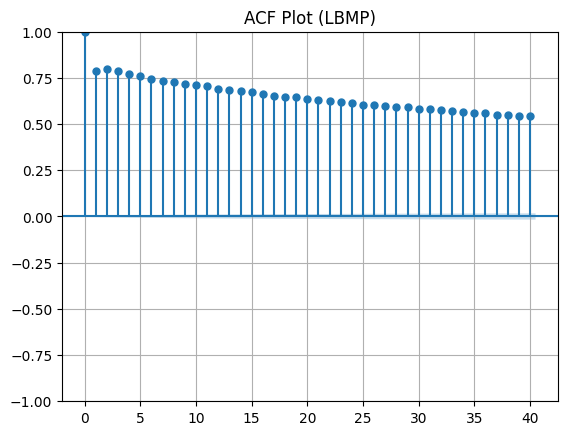

<Figure size 1200x500 with 0 Axes>

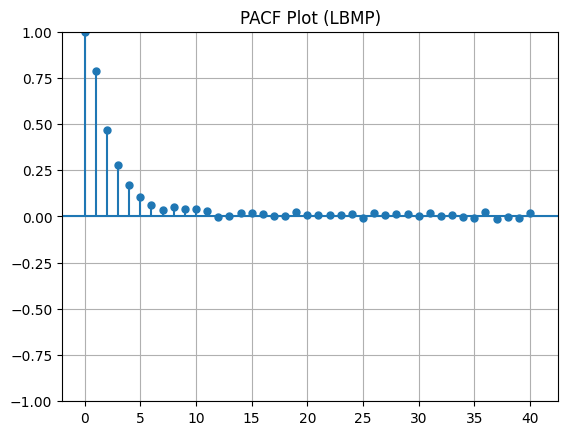

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plot_acf(lbmp_series.dropna(), lags=40)
plt.title("ACF Plot (LBMP)")
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plot_pacf(lbmp_series.dropna(), lags=40)
plt.title("PACF Plot (LBMP)")
plt.grid()
plt.show()


In [ ]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 17.3 MB/s eta 0:00:00


The ACF and PACF charts show AR components with a p of 6. Now let's calculate stationarity.

### Code and result for consumer in project4 - consumer file

In [ ]:
training_pd = training_data.select("timestamp", "LBMP").toPandas()


###Check if the series is stationary or non-stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

training_pd['timestamp'] = pd.to_datetime(training_pd['timestamp'])
training_pd.set_index('timestamp', inplace=True)

adf_result = adfuller(training_pd['LBMP'])
p_value = adf_result[1]

if p_value < 0.05:
    print("The LBMP series is stationary")
else:
    print("The LBMP series is non-stationary")


The LBMP series is stationary


###Conduct anamoly detection on data using ARIMA model

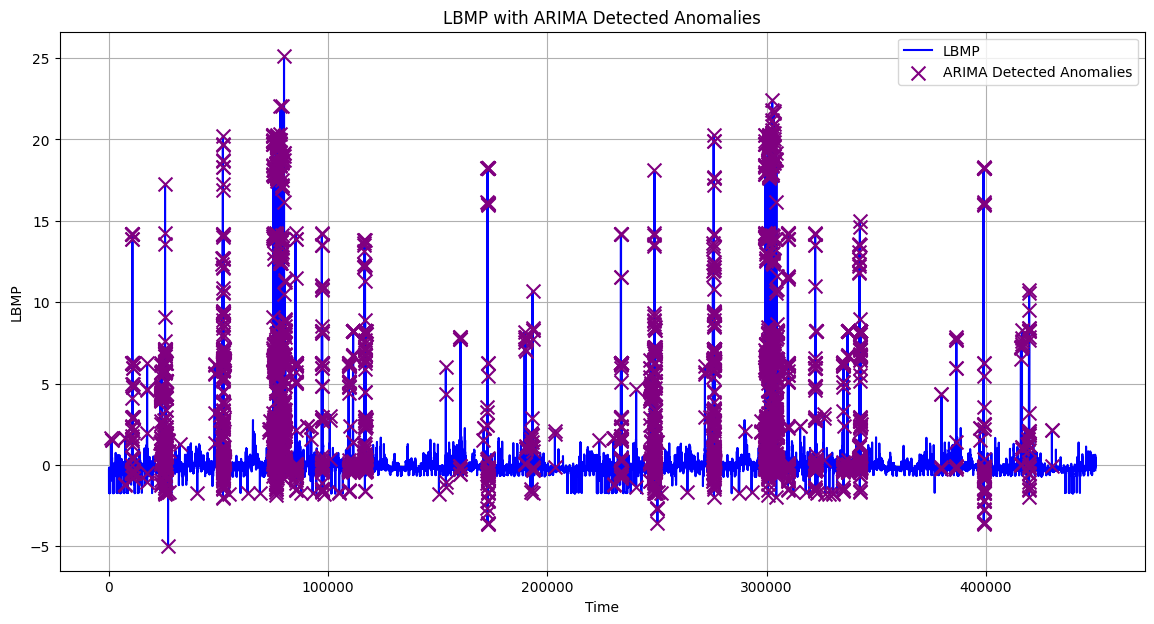

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Paths to save model and thresholds
model_save_path = "/content/drive/Shareddrives/DATS6450-Project4/arima_model.pkl"
threshold_save_path = "/content/drive/Shareddrives/DATS6450-Project4/arima_thresholds.pkl"

# Step 1: Preprocess data
training_pd['LBMP'] = scaler.fit_transform(training_pd[['LBMP']])

training_pd['LBMP'] = pd.to_numeric(training_pd['LBMP'], errors='coerce')
training_pd.dropna(subset=['LBMP'], inplace=True)

# Step 2: Fit ARIMA model
model = ARIMA(training_pd['LBMP'], order=(6, 0, 1))
model_fit = model.fit()

# Save model
model_fit.save(model_save_path)

# Step 3: Generate predictions
predictions = model_fit.predict(start=0, end=len(training_pd) - 1)

# Step 4: Calculate residuals
residuals = training_pd['LBMP'] - predictions

# Step 5: Set anomaly detection threshold
upper = np.mean(residuals) + 3 * np.std(residuals)
lower = np.mean(residuals) - 3 * np.std(residuals)

# Save thresholds
joblib.dump({"upper": upper, "lower": lower}, threshold_save_path)

# Step 6: Mark anomalies
training_pd['ARIMA_Anomaly'] = ((residuals > upper) | (residuals < lower)).astype(int)

# Step 7: Evaluate if ground truth exists
if 'Anomaly' in training_pd.columns:
    precision = precision_score(training_pd['Anomaly'], training_pd['ARIMA_Anomaly'])
    recall = recall_score(training_pd['Anomaly'], training_pd['ARIMA_Anomaly'])
else:
    precision = recall = None

# Step 8: Plot the results
plt.figure(figsize=(14, 7))
plt.plot(training_pd.index, training_pd['LBMP'], label='LBMP', color='blue')

if 'Anomaly' in training_pd.columns:
    plt.scatter(training_pd.index[training_pd['Anomaly'] == 1], training_pd['LBMP'][training_pd['Anomaly'] == 1],
                color='red', label='True Anomalies', zorder=5)

plt.scatter(training_pd.index[training_pd['ARIMA_Anomaly'] == 1], training_pd['LBMP'][training_pd['ARIMA_Anomaly'] == 1],
            color='purple', label='ARIMA Detected Anomalies', marker='x', s=100, zorder=5)

plt.title(f'LBMP with ARIMA Detected Anomalies\nPrecision: {precision:.2f}, Recall: {recall:.2f}' if precision else 'LBMP with ARIMA Detected Anomalies')
plt.xlabel('Time')
plt.ylabel('LBMP')
plt.legend()
plt.grid()
plt.show()


##Producer streaming again for ARIMA model

In [ ]:
import json
from kafka import KafkaProducer
from pyspark.sql.functions import col
import time

# Kafka connection details
TOPIC_NAME = "streaming_11"
SASL_MECHANISM = 'SCRAM-SHA-256'
bootstrap_servers = f"kafka-28c8ad04-rachanak0611-3f37.j.aivencloud.com:19404"
kafka_password = "AVNS_BpO_fc9_Co4g5b3_ehW"


producer = KafkaProducer(
    bootstrap_servers=bootstrap_servers,
    sasl_mechanism=SASL_MECHANISM,
    sasl_plain_username="avnadmin",
    sasl_plain_password=kafka_password,
    security_protocol="SASL_SSL",
    ssl_cafile="/content/drive/Shareddrives/DATS6450-Project4/ca.pem"
)

def send_streaming_data_to_kafka(df, producer, topic_name, duration_seconds=30):
    start_time = time.time()
    for row in df.collect():


        message = {
            "Name": row["Name"],
            "PTID": row["PTID"],
            "LBMP": row["LBMP"],
            "Losses": row["Losses"],
            "Congestion": row["Congestion"],
            "Load": row["Load"],
            "timestamp": row["timestamp"].strftime('%Y-%m-%dT%H:%M:%SZ')
        }

        message_str = json.dumps(message)
        producer.send(topic_name, message_str.encode('utf-8'))
        print(f"Message sent at {time.strftime('%H:%M:%S')} -> {message_str}")
        time.sleep(1)

send_streaming_data_to_kafka(streaming_data, producer, TOPIC_NAME,3000)
producer.close()

Message sent at 21:51:53 -> {"Name": "CENTRL", "PTID": "61754", "LBMP": "22.62", "Losses": 0, "Congestion": 0, "Load": 1498, "timestamp": "2001-06-01T00:00:00Z"}
Message sent at 21:51:54 -> {"Name": "GENESE", "PTID": "61753", "LBMP": "21.99", "Losses": -1, "Congestion": 0, "Load": 841, "timestamp": "2001-06-01T00:00:00Z"}
Message sent at 21:51:55 -> {"Name": "MHK VL", "PTID": "61756", "LBMP": "23.27", "Losses": 0, "Congestion": 0, "Load": 648, "timestamp": "2001-06-01T00:00:00Z"}
Message sent at 21:51:56 -> {"Name": "NORTH", "PTID": "61755", "LBMP": "23.01", "Losses": 0, "Congestion": 0, "Load": 661, "timestamp": "2001-06-01T00:00:00Z"}
Message sent at 21:51:57 -> {"Name": "CAPITL", "PTID": "61757", "LBMP": "16.44", "Losses": 0, "Congestion": 0, "Load": 965, "timestamp": "2001-06-01T00:00:53Z"}
Message sent at 21:51:58 -> {"Name": "MHK VL", "PTID": "61756", "LBMP": "16.15", "Losses": 0, "Congestion": 0, "Load": 622, "timestamp": "2001-06-01T00:00:53Z"}
Message sent at 21:51:59 -> {"Nam

KeyboardInterrupt: 

#Question 3: Forecast future electricity demand (Integrated Load) based on historical electricity prices (LBMP) and grid conditions (marginal costs due to congestion or losses)


In [ ]:
from pyspark.sql.functions import month, to_timestamp

combined_data = combined_data.withColumn("timestamp", to_timestamp("timestamp", "MM/dd/yyyy HH:mm:ss"))

streaming_data = combined_data.filter(month("timestamp").isin([3, 6, 9, 12]))
training_data = combined_data.filter(~month("timestamp").isin([3, 6, 9, 12]))

print("Streaming Data Sample")
streaming_data.show(5)

print("Training Data Sample")
training_data.show(5)


Streaming Data Sample
+-------------------+------+-----+-----+------+----------+---------+----+
|          timestamp|  Name| PTID| LBMP|Losses|Congestion|Time Zone|Load|
+-------------------+------+-----+-----+------+----------+---------+----+
|2001-06-01 00:00:00|CENTRL|61754|22.62| -0.41|      0.00|      EDT|1498|
|2001-06-01 00:00:00|GENESE|61753|21.99| -1.04|      0.00|      EDT| 841|
|2001-06-01 00:00:00|MHK VL|61756|23.27|  0.24|      0.00|      EDT| 648|
|2001-06-01 00:00:00| NORTH|61755|23.01| -0.02|      0.00|      EDT| 661|
|2001-06-01 00:00:53|CAPITL|61757|16.44|  0.49|      0.00|      EDT| 965|
+-------------------+------+-----+-----+------+----------+---------+----+
only showing top 5 rows

Training Data Sample
+-------------------+------+-----+-----+------+----------+---------+----+
|          timestamp|  Name| PTID| LBMP|Losses|Congestion|Time Zone|Load|
+-------------------+------+-----+-----+------+----------+---------+----+
|2001-05-26 00:00:00|CAPITL|61757|20.52|  1.

In [ ]:
pip install tensorflow

### We will be using the LSTM for this case to predict the loss using the price, congestion and Load

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
10124/10124 ━━━━━━━━━━━━━━━━━━━━ 153s 15ms/step - loss: 8.3671e-04 - val_loss: 7.0952e-04
Epoch 2/20
10124/10124 ━━━━━━━━━━━━━━━━━━━━ 148s 15ms/step - loss: 7.3432e-04 - val_loss: 6.7931e-04
Epoch 3/20
10124/10124 ━━━━━━━━━━━━━━━━━━━━ 154s 15ms/step - loss: 7.2133e-04 - val_loss: 6.8012e-04
Epoch 4/20
10124/10124 ━━━━━━━━━━━━━━━━━━━━ 199s 15ms/step - loss: 7.0920e-04 - val_loss: 6.6650e-04
Epoch 5/20
10124/10124 ━━━━━━━━━━━━━━━━━━━━ 209s 16ms/step - loss: 6.9615e-04 - val_loss: 6.6750e-04
Epoch 6/20
10124/10124 ━━━━━━━━━━━━━━━━━━━━ 199s 15ms/step - loss: 6.9306e-04 - val_loss: 6.5393e-04
Epoch 7/20
10124/10124 ━━━━━━━━━━━━━━━━━━━━ 202s 15ms/step - loss: 6.8146e-04 - val_loss: 6.4722e-04
Epoch 8/20
10124/10124 ━━━━━━━━━━━━━━━━━━━━ 200s 15ms/step - loss: 6.7359e-04 - val_loss: 6.4291e-04
Epoch 9/20
10124/10124 ━━━━━━━━━━━━━━━━━━━━ 150s 15ms/step - loss: 6.7417e-04 - val_loss: 6.4877e-04
Epoch 10/20
10124/10124 ━━━━━━━━━━━━━━━━━━━━ 200s 15ms/step - loss: 6.6541e-04 - val_loss: 

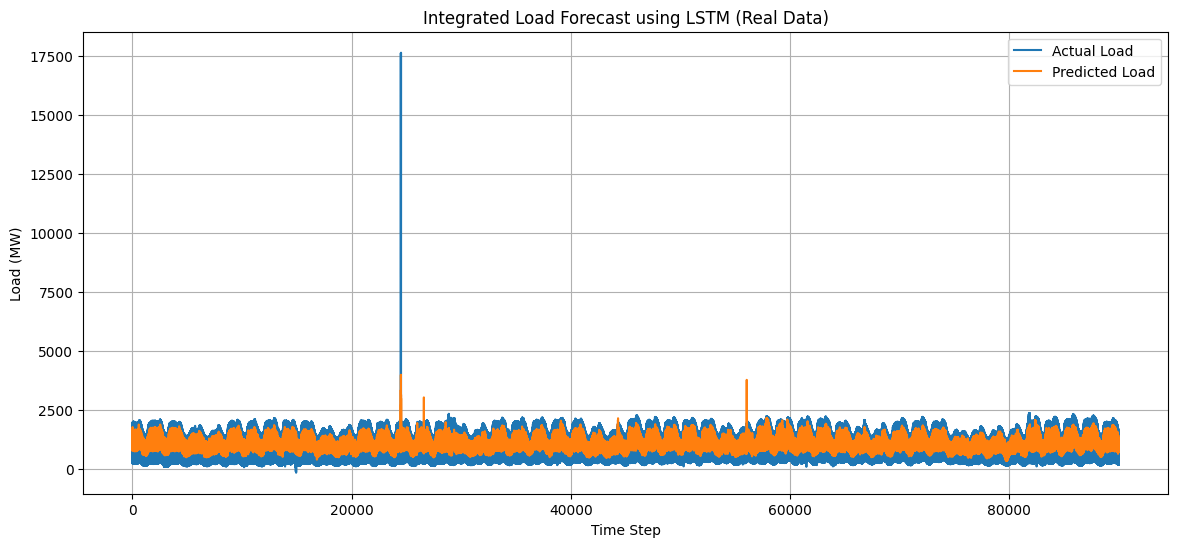

LSTM model saved to: /content/drive/Shareddrives/DATS6450-Project4/lstm_model.h5


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import tensorflow as tf

# -----------------------
# 1. Load your real data
# -----------------------
features = ['LBMP', 'Congestion', 'Losses', 'Load']
training_pd = training_data.select(features).toPandas()
df = training_pd[features].copy()

# -----------------------
# 2. Scale the features
# -----------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=features)

# -----------------------
# 3. Create sequences
# -----------------------
def create_sequences(data, target_index, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][target_index])
    return np.array(X), np.array(y)

sequence_length = 24  # using 24 past hours
target_index = features.index('Load')
X, y = create_sequences(df_scaled.values, target_index, sequence_length)

# -----------------------
# 4. Train-test split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# -----------------------
# 5. Build and train LSTM
# -----------------------
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# -----------------------
# 6. Predict and plot
# -----------------------
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
def inverse_transform(y_scaled, X_scaled_last_part):
    combined = np.concatenate([X_scaled_last_part, y_scaled.reshape(-1, 1)], axis=1)
    return scaler.inverse_transform(combined)[:, -1]

X_test_last = X_test[:, -1, :-1]
y_test_inv = inverse_transform(y_test, X_test_last)
y_pred_inv = inverse_transform(y_pred, X_test_last)

plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Load')
plt.plot(y_pred_inv, label='Predicted Load')
plt.title('Integrated Load Forecast using LSTM (Real Data)')
plt.xlabel('Time Step')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid()
plt.show()

# -----------------------
# 7. Save the model
# -----------------------
model_save_path = "/content/drive/Shareddrives/DATS6450-Project4/lstm_model.h5"
model.save(model_save_path)
print(f"LSTM model saved to: {model_save_path}")


#KAFKA producing code again

In [ ]:
pip install kafka-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.3/307.3 kB 4.0 MB/s eta 0:00:00


In [ ]:
import json
from kafka import KafkaProducer

from pyspark.sql.functions import col
import time

# Kafka connection details
TOPIC_NAME = "streaming_11"
SASL_MECHANISM = 'SCRAM-SHA-256'
bootstrap_servers = f"kafka-28c8ad04-rachanak0611-3f37.j.aivencloud.com:19404"
kafka_password = "AVNS_BpO_fc9_Co4g5b3_ehW"


producer = KafkaProducer(
    bootstrap_servers=bootstrap_servers,
    sasl_mechanism=SASL_MECHANISM,
    sasl_plain_username="avnadmin",
    sasl_plain_password=kafka_password,
    security_protocol="SASL_SSL",
    ssl_cafile="/content/drive/Shareddrives/DATS6450-Project4/ca.pem"
)

def send_streaming_data_to_kafka(df, producer, topic_name, duration_seconds=30):
    start_time = time.time()
    for row in df.collect():


        message = {
            "Name": row["Name"],
            "PTID": row["PTID"],
            "LBMP": row["LBMP"],
            "Losses": row["Losses"],
            "Congestion": row["Congestion"],
            "Load": row["Load"],
            "timestamp": row["timestamp"].strftime('%Y-%m-%dT%H:%M:%SZ')
        }

        message_str = json.dumps(message)
        producer.send(topic_name, message_str.encode('utf-8'))
        print(f"Message sent at {time.strftime('%H:%M:%S')} -> {message_str}")
        time.sleep(1)

send_streaming_data_to_kafka(streaming_data, producer, TOPIC_NAME,3000)
producer.close()

Message sent at 05:04:58 -> {"Name": "CENTRL", "PTID": "61754", "LBMP": "22.62", "Losses": 0, "Congestion": 0, "Load": 1498, "timestamp": "2001-06-01T00:00:00Z"}
Message sent at 05:05:00 -> {"Name": "GENESE", "PTID": "61753", "LBMP": "21.99", "Losses": -1, "Congestion": 0, "Load": 841, "timestamp": "2001-06-01T00:00:00Z"}
Message sent at 05:05:01 -> {"Name": "MHK VL", "PTID": "61756", "LBMP": "23.27", "Losses": 0, "Congestion": 0, "Load": 648, "timestamp": "2001-06-01T00:00:00Z"}
Message sent at 05:05:02 -> {"Name": "NORTH", "PTID": "61755", "LBMP": "23.01", "Losses": 0, "Congestion": 0, "Load": 661, "timestamp": "2001-06-01T00:00:00Z"}
Message sent at 05:05:03 -> {"Name": "CAPITL", "PTID": "61757", "LBMP": "16.44", "Losses": 0, "Congestion": 0, "Load": 965, "timestamp": "2001-06-01T00:00:53Z"}
Message sent at 05:05:04 -> {"Name": "MHK VL", "PTID": "61756", "LBMP": "16.15", "Losses": 0, "Congestion": 0, "Load": 622, "timestamp": "2001-06-01T00:00:53Z"}
Message sent at 05:05:05 -> {"Nam

KeyboardInterrupt: 

##Consumer code for the LSTM model

In [ ]:
from pyspark.sql.functions import col

streaming_data = streaming_data.withColumn("Losses", col("Losses").cast("int")) \
                               .withColumn("Congestion", col("Congestion").cast("int")) \
                               .withColumn("Load", col("Load").cast("int"))


In [ ]:
import json
import numpy as np
import pandas as pd
from kafka import KafkaConsumer
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ----------------------------
# 1. Load model
# ----------------------------
model = load_model("/content/drive/Shareddrives/DATS6450-Project4/lstm_model.h5", compile=False)

# ----------------------------
# 2. Fit MinMaxScaler on historical data
# ----------------------------
# Load or define your historical DataFrame here (this must be run before streaming starts)
features = ['LBMP', 'Congestion', 'Losses', 'Load']
# Example: assume `training_pd` is already defined
df = training_pd[features].copy()

scaler = MinMaxScaler()
scaler.fit(df.values)

# ----------------------------
# 3. Kafka Setup
# ----------------------------
TOPIC_NAME = "streaming_11"
SASL_MECHANISM = 'SCRAM-SHA-256'
bootstrap_servers = "kafka-28c8ad04-rachanak0611-3f37.j.aivencloud.com:19404"
kafka_password = "AVNS_BpO_fc9_Co4g5b3_ehW"

consumer = KafkaConsumer(
    TOPIC_NAME,
    auto_offset_reset="earliest",
    bootstrap_servers=bootstrap_servers,
    client_id="CONSUMER_CLIENT_ID",
    group_id="CONSUMER_GROUP_ID",
    sasl_mechanism=SASL_MECHANISM,
    sasl_plain_username="avnadmin",
    sasl_plain_password=kafka_password,
    security_protocol="SASL_SSL",
    ssl_cafile="/content/drive/Shareddrives/DATS6450-Project4/ca.pem",
    value_deserializer=lambda x: json.loads(x.decode('utf-8')),
    request_timeout_ms=60000,
    session_timeout_ms=30000,
    heartbeat_interval_ms=10000,
    max_poll_interval_ms=600000
)

# ----------------------------
# 4. Streaming Prediction and MSE Calculation
# ----------------------------
sequence_length = 100
sliding_window = []
predictions = []
actual_load = []
mse_values = []

print("Kafka consumer running...")

for msg in consumer:
    try:
        parsed = msg.value
        input_features = [float(parsed[feature]) for feature in features]
        sliding_window.append(input_features)

        if len(sliding_window) > sequence_length:
            sliding_window.pop(0)

        if len(sliding_window) == sequence_length:
            input_np = np.array(sliding_window)
            input_scaled = scaler.transform(input_np)
            input_seq = input_scaled.reshape(1, sequence_length, len(features))

            # Predict the load using the model
            predicted_scaled = model.predict(input_seq)
            last_input_features = input_scaled[-1, :-1].reshape(1, -1)
            combined = np.concatenate([last_input_features, predicted_scaled], axis=1)
            predicted_actual = scaler.inverse_transform(combined)[0, -1]

            actual_value = parsed['Load']  # Actual load from the incoming message

            # Collect predictions and actual values
            predictions.append(predicted_actual)
            actual_load.append(actual_value)

            # Calculate MSE for every 1000 rows
            if len(predictions) == 1000:
                mse = mean_squared_error(actual_load, predictions)
                mse_values.append(mse)

                print(f"MSE for 1000 rows: {mse:.4f}")

                # Reset lists to start new evaluation
                predictions.clear()
                actual_load.clear()

            # Print the predicted load
            print(f"Predicted Load: {predicted_actual:.2f} MW, Actual Load: {actual_value:.2f} MW")

        else:
            print(f"Waiting for {sequence_length - len(sliding_window)} more records...")

    except Exception as e:
        print(f"Error during prediction: {e}")

# ----------------------------
# 5. Plot Predictions vs Actuals
# ----------------------------



Kafka consumer running...
Waiting for 99 more records...
Waiting for 98 more records...
Waiting for 97 more records...
Waiting for 96 more records...
Waiting for 95 more records...
Waiting for 94 more records...
Waiting for 93 more records...
Waiting for 92 more records...
Waiting for 91 more records...
Waiting for 90 more records...
Waiting for 89 more records...
Waiting for 88 more records...
Waiting for 87 more records...
Waiting for 86 more records...
Waiting for 85 more records...
Waiting for 84 more records...
Waiting for 83 more records...
Waiting for 82 more records...
Waiting for 81 more records...
Waiting for 80 more records...
Waiting for 79 more records...
Waiting for 78 more records...
Waiting for 77 more records...
Waiting for 76 more records...
Waiting for 75 more records...
Waiting for 74 more records...
Waiting for 73 more records...
Waiting for 72 more records...
Waiting for 71 more records...
Waiting for 70 more records...
Waiting for 69 more records...
Waiting for 6

KeyboardInterrupt: 

### Lets now perform LSTM predcition on whole streaming_data dataframe to check the overall RMSE

9907/9907 ━━━━━━━━━━━━━━━━━━━━ 330s 33ms/step


ERROR:kafka.coordinator:Heartbeat thread for group CONSUMER_GROUP_ID failed due to unexpected error: cannot release un-acquired lock


Mean Squared Error: 295302.5857


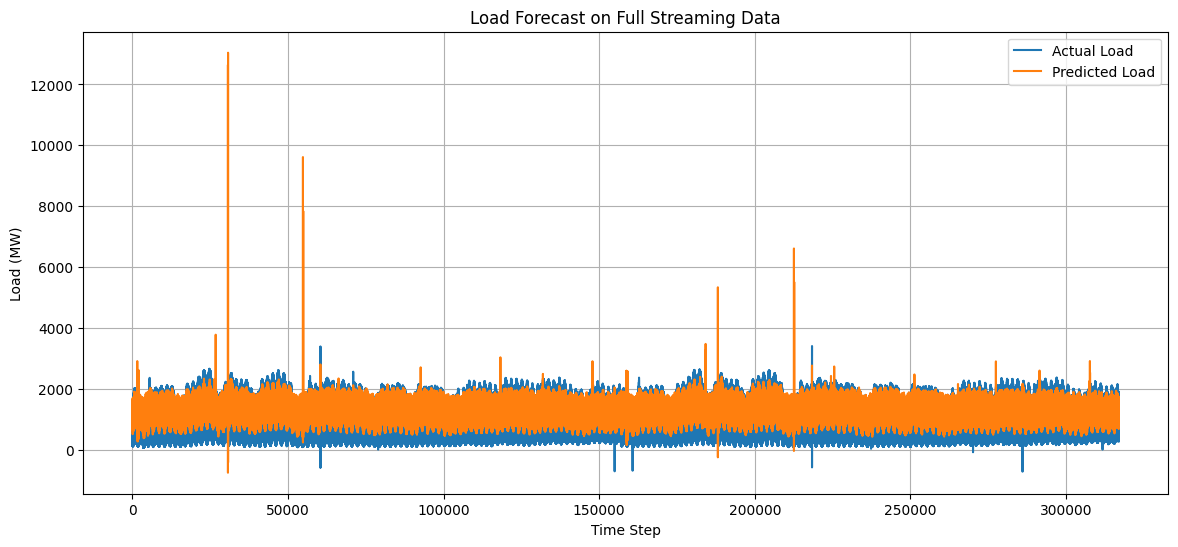

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Ensure your streaming_data DataFrame has the required columns
features = ['LBMP', 'Congestion', 'Losses', 'Load']
streaming_pd = streaming_data.select(features).toPandas()
df = streaming_pd[features].copy()

# Scale data
scaled = scaler.transform(df.values)

# Create sliding windows
sequence_length = 100
X_all, y_all = [], []

for i in range(len(scaled) - sequence_length):
    X_all.append(scaled[i:i+sequence_length])
    y_all.append(scaled[i+sequence_length][-1])  # scaled Load

X_all = np.array(X_all)
y_all = np.array(y_all)

# Predict
y_pred_scaled = model.predict(X_all)

# Inverse transform predictions and actuals
def inverse_transform(y_scaled, X_scaled_last_part):
    combined = np.concatenate([X_scaled_last_part, y_scaled.reshape(-1, 1)], axis=1)
    return scaler.inverse_transform(combined)[:, -1]

# Get last 3 features (excluding Load) from the last row of each sequence
X_last_features = X_all[:, -1, :-1]  # shape (n, 3)

# Inverse transform predictions and actuals
y_pred_inv = inverse_transform(y_pred_scaled, X_last_features)
y_test_inv = inverse_transform(y_all, X_last_features)

# Compute MSE
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Mean Squared Error: {mse:.4f}")

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Actual Load')
plt.plot(y_pred_inv, label='Predicted Load')
plt.title('Load Forecast on Full Streaming Data')
plt.xlabel('Time Step')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid()
plt.show()


As seen the above graph and RMSE with around 543. The model works pretty well.